# EXP-S1-001
## Date: 07-09-21
### Author: Daniel Díaz

---
#### Summary
Create a new graph with all data used in Karimi approach.

---

Table of contents
1. Load libraries
2. Load data
3. Karimi Approach
4. Build a new graph

## Load libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from similarity import Similarity

import pmtools2 as pm
import kmodes
%matplotlib inline

## Load data

In [12]:
url_data = 'data/train.csv'
df_emp_access = pd.read_csv(url_data)
attnames_list = list(df_emp_access.columns)
print("Columns :", attnames_list)

Columns : ['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


In [13]:
entries = df_emp_access.values.tolist()
attidx_to_collcounter = pm.get_entries_freqs(entries)

print('#Entries:', len(entries))
print('#Users:', len(df_emp_access[attnames_list[2:]].drop_duplicates()))
print()

print('---Attributes---')
for att_idx in range(len(attnames_list)):
    print('Num values', attnames_list[att_idx], ':', len(attidx_to_collcounter[att_idx].keys()))
num_resources = attnames_list[1]
    
print()
df_pos_entries = df_emp_access[df_emp_access['ACTION']==1]
df_neg_entries = df_emp_access[df_emp_access['ACTION']==0]
print('Num positive entries:',len(df_pos_entries))
print('Num negative entries:',len(df_neg_entries))

#Entries: 32769
#Users: 9561

---Attributes---
Num values ACTION : 2
Num values RESOURCE : 7518
Num values MGR_ID : 4243
Num values ROLE_ROLLUP_1 : 128
Num values ROLE_ROLLUP_2 : 177
Num values ROLE_DEPTNAME : 449
Num values ROLE_TITLE : 343
Num values ROLE_FAMILY_DESC : 2358
Num values ROLE_FAMILY : 67
Num values ROLE_CODE : 343

Num positive entries: 30872
Num negative entries: 1897


## Karimi approach

### Preprocessing

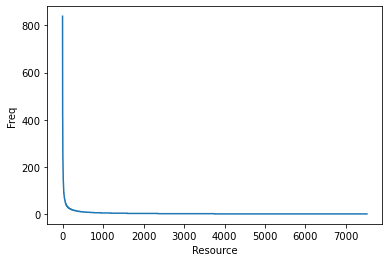

In [14]:
#A_V Resource distribution
res_to_freq = (df_emp_access['RESOURCE'].value_counts()).to_dict()
res_to_freq_lists = res_to_freq.items()
x_list, y_list = zip(*res_to_freq_lists)
plt.plot(y_list)
plt.ylabel('Freq')
plt.xlabel('Resource')
plt.show()

In [16]:
#B_I Filter resources

#DO NOT CHANGE THIS CODE
n1 = 0
n2 = 69
num_resources = 7518
top_list = df_emp_access['RESOURCE'].value_counts()[:num_resources].index.tolist()
#Filter the interval between n1 and n2
top_list = top_list[n1:n2+1]
print('#Filtered resources:', len(top_list))

#Filtered resources: 70


In [17]:
#B_II Remove useless attributes

#DO NOT CHANGE THIS CODE
attnames_list_ = [name for name in attnames_list]
attnames_list_.remove('ACTION')
attnames_list_.remove('MGR_ID')
attnames_list_.remove('ROLE_FAMILY_DESC')

print('Three attributes removed!')

Three attributes removed!


In [18]:
#B_II Data splitting

#DO NOT CHANGE THIS CODE
boolean_series = df_pos_entries.RESOURCE.isin(top_list)
df_pos_entries_ = df_pos_entries[boolean_series]
boolean_series = df_neg_entries.RESOURCE.isin(top_list)
df_neg_entries_ = df_neg_entries[boolean_series]

pos_entries = df_pos_entries_[attnames_list_].values.tolist()
neg_entries = df_neg_entries_[attnames_list_].values.tolist()

print('---Positive entries---')
print('Total:',len(pos_entries))
attidx_to_collcounter_pos = pm.get_entries_freqs(pos_entries)
for att_idx in range(len(attnames_list_)):
    print('Num values', attnames_list_[att_idx], ':', len(attidx_to_collcounter_pos[att_idx].keys()))

print()
print('---Negative entries---')
print('Total:',len(neg_entries))
attidx_to_collcounter_neg = pm.get_entries_freqs(neg_entries)
for att_idx in range(len(attnames_list_)):
    print('Num values', attnames_list_[att_idx], ':', len(attidx_to_collcounter_neg[att_idx].keys()))

---Positive entries---
Total: 9182
Num values RESOURCE : 70
Num values ROLE_ROLLUP_1 : 116
Num values ROLE_ROLLUP_2 : 151
Num values ROLE_DEPTNAME : 391
Num values ROLE_TITLE : 295
Num values ROLE_FAMILY : 63
Num values ROLE_CODE : 295

---Negative entries---
Total: 478
Num values RESOURCE : 67
Num values ROLE_ROLLUP_1 : 57
Num values ROLE_ROLLUP_2 : 77
Num values ROLE_DEPTNAME : 155
Num values ROLE_TITLE : 99
Num values ROLE_FAMILY : 38
Num values ROLE_CODE : 99


### Clustering

In [19]:
###Select the number of clusters###
num_clusters = 40

#DO NOT CHANGE THIS CODE
seed = 29
#Compute centroids and labels
num_init = 5
centroids = []
kmodes_huang = kmodes.KModes(n_clusters=num_clusters, n_init=num_init, init='Huang', verbose=0, random_state=seed)
cluster_labels = kmodes_huang.fit_predict(pos_entries)
centroids = kmodes_huang.cluster_centroids_

print('Ready!')    

/home/daniel/anaconda3/envs/tesis_env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Ready!


In [20]:
###Select the threshold###
threshold = 0.35

#DO NOT CHANGE THIS CODE
policy = pm.create_policy(pos_entries, cluster_labels, centroids, num_clusters, threshold)

print('WSC:', pm.compute_wsc(policy))
false_negs,_,precision,recall,fscore = pm.evaluate_policy(policy, pos_entries, neg_entries)
print('Precision:',precision)
print('Recall:',recall)
print('F-score:',fscore)

WSC: 141
Precision: 0.9566380133715378
Recall: 0.5454149422783707
F-score: 0.6947353818408823


## Graph approach

### Preprocessing

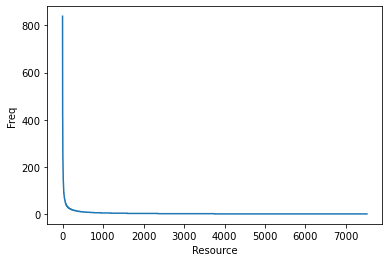

In [21]:
#A_V Resource distribution
res_to_freq = (df_emp_access['RESOURCE'].value_counts()).to_dict()
res_to_freq_lists = res_to_freq.items()
x_list, y_list = zip(*res_to_freq_lists)
plt.plot(y_list)
plt.ylabel('Freq')
plt.xlabel('Resource')
plt.show()

In [22]:
#B_I Filter resources

#DO NOT CHANGE THIS CODE
n1 = 0
n2 = 69
num_resources = 7518
top_list = df_emp_access['RESOURCE'].value_counts()[:num_resources].index.tolist()
#Filter the interval between n1 and n2
top_list = top_list[n1:n2+1]
print('#Filtered resources:', len(top_list))

#Filtered resources: 70


In [23]:
#B_II Remove useless attributes

#DO NOT CHANGE THIS CODE
attnames_list_ = [name for name in attnames_list]
attnames_list_.remove('ACTION')
attnames_list_.remove('MGR_ID')
attnames_list_.remove('ROLE_FAMILY_DESC')

print('Three attributes removed!')

Three attributes removed!


In [24]:
#B_II Data splitting

#DO NOT CHANGE THIS CODE
boolean_series = df_pos_entries.RESOURCE.isin(top_list)
df_pos_entries_ = df_pos_entries[boolean_series]
boolean_series = df_neg_entries.RESOURCE.isin(top_list)
df_neg_entries_ = df_neg_entries[boolean_series]

pos_entries = df_pos_entries_[attnames_list_].values.tolist()
neg_entries = df_neg_entries_[attnames_list_].values.tolist()

print('---Positive entries---')
print('Total:',len(pos_entries))
attidx_to_collcounter_pos = pm.get_entries_freqs(pos_entries)
for att_idx in range(len(attnames_list_)):
    print('Num values', attnames_list_[att_idx], ':', len(attidx_to_collcounter_pos[att_idx].keys()))

print()
print('---Negative entries---')
print('Total:',len(neg_entries))
attidx_to_collcounter_neg = pm.get_entries_freqs(neg_entries)
for att_idx in range(len(attnames_list_)):
    print('Num values', attnames_list_[att_idx], ':', len(attidx_to_collcounter_neg[att_idx].keys()))

---Positive entries---
Total: 9182
Num values RESOURCE : 70
Num values ROLE_ROLLUP_1 : 116
Num values ROLE_ROLLUP_2 : 151
Num values ROLE_DEPTNAME : 391
Num values ROLE_TITLE : 295
Num values ROLE_FAMILY : 63
Num values ROLE_CODE : 295

---Negative entries---
Total: 478
Num values RESOURCE : 67
Num values ROLE_ROLLUP_1 : 57
Num values ROLE_ROLLUP_2 : 77
Num values ROLE_DEPTNAME : 155
Num values ROLE_TITLE : 99
Num values ROLE_FAMILY : 38
Num values ROLE_CODE : 99


### Build the graph

In [43]:
# Similarity configuration
df_pos_entries_new = df_pos_entries_[attnames_list_]
#df_pos_entries_new = df_pos_entries_new.sample(n=250)
# Umbral
umbral = 0.2
# Calcular matriz de distancias
cal_mat_dist = False
# Generar archivo
cal_file = False
df_pos_entries_new

,RESOURCE,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY,ROLE_CODE
6,25993,117961,118343,123476,118980,118295,118982
10,4675,117961,118413,118481,118784,290919,118786
13,4675,91261,118026,118202,119962,118205,119964
23,1020,117961,118300,120410,118321,290919,118322
24,4675,117961,118052,118867,118259,290919,118261
...,...,...,...,...,...,...,...
32755,42085,117961,118052,118821,117905,290919,117908
32760,17308,117961,118225,123173,119093,119095,119096
32764,23497,117961,118300,119993,118321,290919,118322
32766,34924,117961,118327,120299,124922,118612,124924


In [44]:
# Create edges with overlap similarity
lista_edges_o = Similarity.overlap_similarity(df_pos_entries_new, umbral, cal_mat_dist, cal_file)

********************
Iniciando construcción de aristas por OVERLAP


In [38]:
weighted_edges = True
def generate_graph_from_list(list_edges, weighted_=False):
    G = nx.Graph()
    if weighted_:
        G.add_weighted_edges_from(list_edges)
    else:
        G.add_edges_from(list_edges)
    print("#####*****#####")
    print("Grafo contruido!")
    return G


G = generate_graph_from_list(lista_edges_o, weighted_edges)

#####*****#####
Grafo contruido!


In [39]:
print("Vertices:\t",G.number_of_nodes())
print("Aristas:\t",G.number_of_edges())
# Grado promedio
d = nx.degree(G)
suma = 0
for i,j in d:
  #print(d[i])
  suma += j
print("Avg. Degree:\t", suma/len(d))
#print("Diameter: ",nx.distance_measures.diameter(G))
print("Avg. Cluster Coefficient: ", nx.algorithms.average_clustering(G))
#print("Avg. Shortest Path: ",nx.average_shortest_path_length(G))
print("Density: ", nx.density(G))
print("Connected Component", nx.components.number_connected_components(G))

Vertices:	 248
Aristas:	 4813
Avg. Degree:	 38.814516129032256
Avg. Cluster Coefficient:  0.6776941103017393
Density:  0.15714378999608203
Connected Component 2
